<a href="https://colab.research.google.com/github/CagataySencan/TrafficSignRecognition/blob/main/Detection_with_YOLOv4_Recognition_with_CNN-revizee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1- Gerekli Kütüphanelerin Eklenmesi


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import  PIL
from sklearn.preprocessing import LabelEncoder
from PIL import  ImageEnhance , ImageOps , Image
from matplotlib import pyplot
from keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import seaborn as sbn
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
! git clone https://github.com/CagataySencan/TrafficSignRecognition
! git clone https://github.com/AlexeyAB/darknet/

# 2- Verisetinlerini Kaggle'dan Çekmek İçin Gerekli İşlemler


In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
! kaggle datasets download hieunguyen21/german-traffic-sign-detection-benchmark-gtsdb

In [ ]:
! unzip gtsrb-german-traffic-sign.zip
! unzip german-traffic-sign-detection-benchmark-gtsdb.zip

# 3- YOLO (You Only Look Once)

# 3.1 Veriyi YOLO Formatına Getirme

In [ ]:
classes = {0:'prohibitory',
           1:'danger',
           2:'mandatory',
           3:'other'}
           
c = pd.DataFrame([classes])
c.to_csv('/content/classes.names', header=False, index=False, sep='\n')

Trafik işareti sınıflarını 4 üst sınıfa ayırma işlemi

In [ ]:
# Prohibitory : Beyaz arkaplanlı kırmızı sınırlı daire şeklindeki işaretler
p = [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 15, 16]

# Danger : Beyaz arkaplanlı kırmızı sınırlı üçgen işaretler
d = [11, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

# Mandatory : Mavi arkaplanlı daire şeklindeki işaretler
m = [33, 34, 35, 36, 37, 38, 39, 40]

# Diğer:
o = [6, 12, 13, 14, 17, 32, 41, 42]

gt.txt dosyasından ihtiyaç duyulan verileri çekme ve güncelleme

In [ ]:
# Her fotoğraf için annotation txt dosyalarının oluşturulması için ön hazırlık
ann = pd.read_csv('/content/FullIJCNN2013/gt.txt',
                  names=['ImageID',
                         'XMin',
                         'YMin',
                         'XMax',
                         'YMax',
                         'ClassID'],
                  sep=';')

# Sayıları YOLO Formatında kaydetmek için dataFrame'e boş sütun eklenmesi
ann['CategoryID'] = ''
ann['center x'] = ''
ann['center y'] = ''
ann['width'] = ''
ann['height'] = ''

# Class ID ye uygun Category ID alınması
ann.loc[ann['ClassID'].isin(p), 'CategoryID'] = 0
ann.loc[ann['ClassID'].isin(d), 'CategoryID'] = 1
ann.loc[ann['ClassID'].isin(m), 'CategoryID'] = 2
ann.loc[ann['ClassID'].isin(o), 'CategoryID'] = 3

# Bounding box'un merkezinin her satır için bulunması ve kaydedilmesi
ann['center x'] = (ann['XMax'] + ann['XMin']) / 2
ann['center y'] = (ann['YMax'] + ann['YMin']) / 2

# Bounding box'un uzunluk ve genişliğinin her satır için bulunması ve kaydedilmesi
ann['width'] = ann['XMax'] - ann['XMin']
ann['height'] = ann['YMax'] - ann['YMin']

# DataFrame'in sadece gerekli datalar için parse edilmesi
r = ann.loc[:, ['ImageID',
                'CategoryID',
                'center x',
                'center y',
                'width',
                'height']].copy()

# 3.2 Her Görüntü İçin Annotation TXT dosyası Oluşturma İşlemi

In [ ]:
def annotation(fullPathtoDataset):
  os.chdir(fullPathtoDataset)

  for current_dir, dirs, files in os.walk('.'):
     for f in files:
        if f.endswith('.ppm'):
          image_ppm = cv2.imread(f)
          h, w = image_ppm.shape[:2]

          # dosyanın yalnızca adını alınması
          image_name = f[:-4]

          sub_r = r.loc[r['ImageID'] == f].copy()

          # Bounding box'un koordinatlarının normalizasyonu
          sub_r['center x'] = sub_r['center x'] / w
          sub_r['center y'] = sub_r['center y'] / h
          sub_r['width'] = sub_r['width'] / w
          sub_r['height'] = sub_r['height'] / h

          resulted_frame = sub_r.loc[:, ['CategoryID',
                                         'center x',
                                         'center y',
                                         'width',
                                         'height']].copy()

          # Annotation kontrolü
          if resulted_frame.isnull().values.all():
              continue

          # Txt dosyalarının kaydedilmesi için path
          path_to_save = fullPathtoDataset + '/' + image_name + '.txt'

          # DataFrame'in txt'ye kaydedilmesi
          resulted_frame.to_csv(path_to_save, header=False, index=False, sep=' ')

          # jpg dosyalarının kaydedilmesi için path
          path_to_save = fullPathtoDataset + '/' + image_name + '.jpg'

          # Görüntülerin jpg formatında kaydedilmesi
          cv2.imwrite(path_to_save, image_ppm)

In [ ]:
annotation('/content/FullIJCNN2013')

# 3.3 Train ve Test TXT Dosyaları Oluşturma İşlemi

In [ ]:
full_path_to_images = '/content/FullIJCNN2013'

os.chdir(full_path_to_images)

# Görüntülerin path'lerinin kaydedileceği boş liste
p = []

# Bütün görüntüleri kontrol edip jpg uzantılarının pathlerinin boş listeye eklenmesi
for current_dir, dirs, files in os.walk('.'):
    for f in files:
        if f.endswith('.jpg'):
            path_to_save_into_txt_files = full_path_to_images + '/' + f
            p.append(path_to_save_into_txt_files + '\n')


# Test için görüntü ayrımı
p_test = p[:int(len(p) * 0.15)]

# Test dataasının listeden çıkarımı
p = p[int(len(p) * 0.15):]

# Train ve Test txt dosyalarını oluşturma
with open('train.txt', 'w') as train_txt:
    for e in p:
        train_txt.write(e)

with open('test.txt', 'w') as test_txt:
    for e in p_test:
        test_txt.write(e)

# 3.4 Darknet Kurulumu ve Data Dosyası

In [ ]:
os.chdir('/content')

In [ ]:
os.chdir('/content/darknet')
#compiling w cuda
! sed -i 's/GPU=0/GPU=1/g' Makefile

! sed -i 's/CUDNN=0/CUDNN=1/g' Makefile

#compiling w openCv
import cv2
! sed -i 's/OPENCV=0/OPENCV=1/g' Makefile

In [ ]:
with open('/content/darknet/cfg/ts_data.data', 'w') as out:
  out.write('classes = 4\n')
  out.write('train = /content/FullIJCNN2013/train.txt\n')
  out.write('valid = /content/FullIJCNN2013/test.txt\n')
  out.write('names = /content/classes.names\n')
  out.write('backup = backup')

In [ ]:
os.chdir('/content/darknet')
! make

In [ ]:
!./darknet

# 3.5 Eğitim

In [ ]:
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.weights

In [ ]:
!./darknet detector train /content/darknet/cfg/ts_data.data /content/TrafficSignRecognition/yolov4-tiny_train.cfg /content/TrafficSignRecognition/yolov4-tiny_train_final.weights -thresh 0.25 -dont_show

# 3.6 En iyi ağırlık dosyasının seçme

In [ ]:
# Son iki ağırlık dosyası için Mean Average Precision
!./darknet detector map /content/darknet/cfg/ts_data.data /content/TrafficSignRecognition/yolov4-tiny_train.cfg /content/TrafficSignRecognition/yolov4-tiny_train_8000.weights

# 3.7 Test İşlemi

In [ ]:
!./darknet detector test /content/darknet/cfg/ts_data.data /content/TrafficSignRecognition/yolov4-tiny_test.cfg /content/TrafficSignRecognition/yolov4-tiny_train_final.weights /content/IMG_0674.jpg -thresh 0.3

# 4- CNN (Convolutional Neural Network)

# 4.1 CNN için Veri Önişleme Aşamaları

In [ ]:
os.chdir('/content')

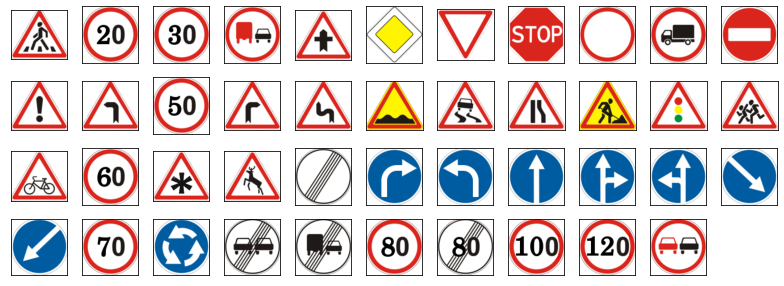

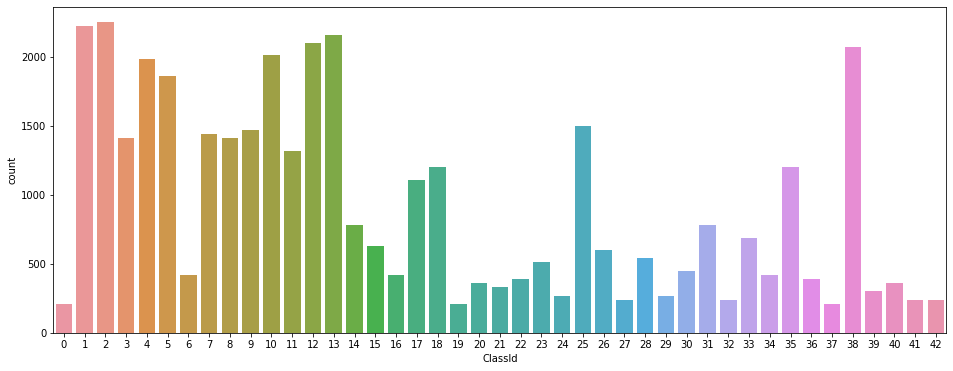

In [ ]:
trainDatas = pd.DataFrame(pd.read_csv('Train.csv'))
testDatas = pd.DataFrame(pd.read_csv('Test.csv'))
metaDatas = pd.read_csv('Meta.csv')
allDatas = pd.concat((trainDatas,testDatas),sort = False).reset_index(drop = True)
classCount = len(trainDatas['ClassId'].value_counts())
classes = { 0:'Hız Limiti (20km/s)',
            1:'Hız Limiti (30km/s)', 
            2:'Hız Limiti (50km/s)', 
            3:'Hız Limiti (60km/s)', 
            4:'Hız Limiti (70km/s)', 
            5:'Hız Limiti (80km/s)', 
            6:'Hız Limitinin bitişi (80km/s)', 
            7:'Hız Limiti (100km/s)', 
            8:'Hız Limiti (120km/s)', 
            9:'Geçiş yok', 
            10:'Ağırlığı 3.5 ton üstü olan araçlar geçemez', 
            11:'Kavşakta geçiş hakkı', 
            12:'Öncelikli yol', 
            13:'Yol ver', 
            14:'Dur', 
            15:'Araç giremez', 
            16:'3.5 Ton üzeri araçlar yasak', 
            17:'Giriş yok', 
            18:'Genel uyarı', 
            19:'Sola tehlikeli viraj', 
            20:'Sağa tehlikeli viraj', 
            21:'Sağa tehlikeli devamlı virajlar', 
            22:'Engebeli yol', 
            23:'Kaygan yol', 
            24:'Sağdan daralan yol', 
            25:'Yol çalışması', 
            26:'Trafik işaretleri', 
            27:'Yaya geçidi', 
            28:'Okul geçidi', 
            29:'Bisiklet yolu', 
            30:'Buzlanmaya dikkat',
            31:'Vahşi hayvan çıkabilir', 
            32:'Hız sınırı sonu', 
            33:'Sadece sağa dönüş var', 
            34:'Sadece sola dönüş var', 
            35:'Dönüş yok', 
            36:'Sola dönüş yok', 
            37:'Sağa dönüş yok', 
            38:'Sağdan gidin', 
            39:'Soldan gidin', 
            40:'Dönüş önceliği', 
            41:'Geçiş olmayan yolun sonu', 
            42:'3.5 Ton üzeri araçlar girebilir' }

# Veri setindeki sınıfları bastıralım
plt.figure(figsize=(11,6))
for i in range(43): 
 plt.subplot(6,11,i+1)
 plt.imshow(Image.open(metaDatas['Path'][i]))
 plt.xticks([])
 plt.yticks([])
 
plt.tight_layout()

# Veri dağılımına bakalım 
plt.figure(figsize=(16,6))
sbn.countplot(x=trainDatas['ClassId'])

In [ ]:
# Eksik veri kontrolü
print("-Eğitim verisi-\n",trainDatas.isnull().sum(),"\n-------------\n","-Test Verisi-\n",testDatas.isnull().sum())
# Eksik veri bulunamadı

# Uyumsuz veri kontrolü, .png ile bitmeyen bir görüntüye sahip olan satır verisetinden çıkarılacak
for i in trainDatas['Path'] : 
  if i.endswith('.png') == False :
    trainDatas.drop(i.index)
    print(i,". satır siliniyor")

for i in testDatas['Path'] :
  if i.endswith('.png') == False:
    testDatas.drop(i.index)
    print(i,". satır siliniyor")

-Eğitim verisi-
 Width      0
Height     0
Roi.X1     0
Roi.Y1     0
Roi.X2     0
Roi.Y2     0
ClassId    0
Path       0
dtype: int64 
-------------
 -Test Verisi-
 Width      0
Height     0
Roi.X1     0
Roi.Y1     0
Roi.X2     0
Roi.Y2     0
ClassId    0
Path       0
dtype: int64


# 4.2 Görüntülerin Yeniden Boyutlandırılması

In [ ]:
# Görüntüleri uygun formata getirme işlemi
height = 30
width = 30
channel = 3

trainData = []
trainLabel = []
for i in range(43) :
    path = "/content/Train/{0}/".format(i)

    Class=os.listdir(path)
    for a in Class:
        try:
            image=cv2.imread(path+a)
            image_from_array = Image.fromarray(image, 'RGB')
            size_image = image_from_array.resize((height, width))
            trainData.append(np.array(size_image))
            trainLabel.append(i)
        except AttributeError:
            print(" ")

trainData = np.array(trainData)
trainLabel = np.array(trainLabel)
print(trainData.shape, trainLabel.shape)

labels = testDatas["ClassId"].values
imgs = testDatas["Path"].values

data =[]

for i in range(len(testDatas['Path'].value_counts())):
    try:
        image = cv2.imread(testDatas["Path"][i])
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((height,width))
        data.append(np.array(resize_image))
    except:
        print("Error in ")
X_Test = np.array(data)
X_Test = X_Test/255

(39209, 30, 30, 3) (39209,)


# 4.3 Verinin Doğrulama ve Test İçin Bölünmesi

In [ ]:
# Eğitim verimizin validation ve eğitim kısmına bölünmesi
X_Train, X_Validate, Y_Train, Y_Validate = train_test_split(trainData,trainLabel,test_size=0.3,random_state=42)

X_Train = X_Train/255 
X_Validate = X_Validate/255 
print(X_Train.shape,X_Validate.shape)
# Validation ve eğitim için veriler bölündü

(27446, 30, 30, 3) (11763, 30, 30, 3)


In [ ]:
Y_Train = to_categorical(Y_Train,num_classes = 43)
Y_Validate = to_categorical(Y_Validate,num_classes = 43)

print(Y_Train.shape)
print(Y_Validate.shape)

(27446, 43)
(11763, 43)


# 4.4 CNN Modelinin Oluşturulması

In [ ]:
from tensorflow.python.keras.layers.normalization.batch_normalization import BatchNormalization
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(height,width,channel)))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis = -1))


model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis = -1))



model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

# 4.5 Augmentation

In [ ]:
# Augmentation işlemi
# Realtime augmentation yapıldığı için gözle görülür bir artış olmamakla beraber trainGen'i  eğitimde kullanacağımızda bizim için augmentation yapacak
trainGen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

validateGen = ImageDataGenerator(rescale=1./255)
testGen = ImageDataGenerator(rescale=1./255)

# 4.6 Modelin Çalıştırılması

In [ ]:
epochs = 30
history = model.fit(trainGen.flow(X_Train, Y_Train, batch_size=32), epochs=epochs,
validation_data=(X_Validate, Y_Validate))

# 4.7 Sonuçların Analiz Edilmesi

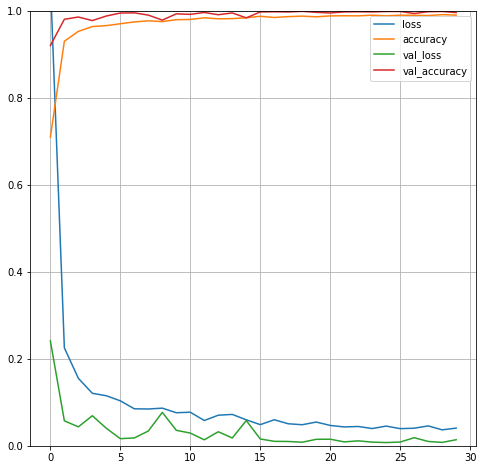

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Accuracy score : % 97.92557403008709
              precision    recall  f1-score   support

           0       0.78      1.00      0.88        60
           1       0.95      1.00      0.97       720
           2       0.97      0.99      0.98       750
           3       1.00      0.96      0.98       450
           4       1.00      0.98      0.99       660
           5       0.98      0.99      0.98       630
           6       1.00      0.85      0.92       150
           7       0.98      1.00      0.99       450
           8       0.99      0.99      0.99       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       1.00      0.93      0.96       420
          12       1.00      0.94      0.97       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.98      1.00      0.99       210
          16       1.00      1.00      1.00 

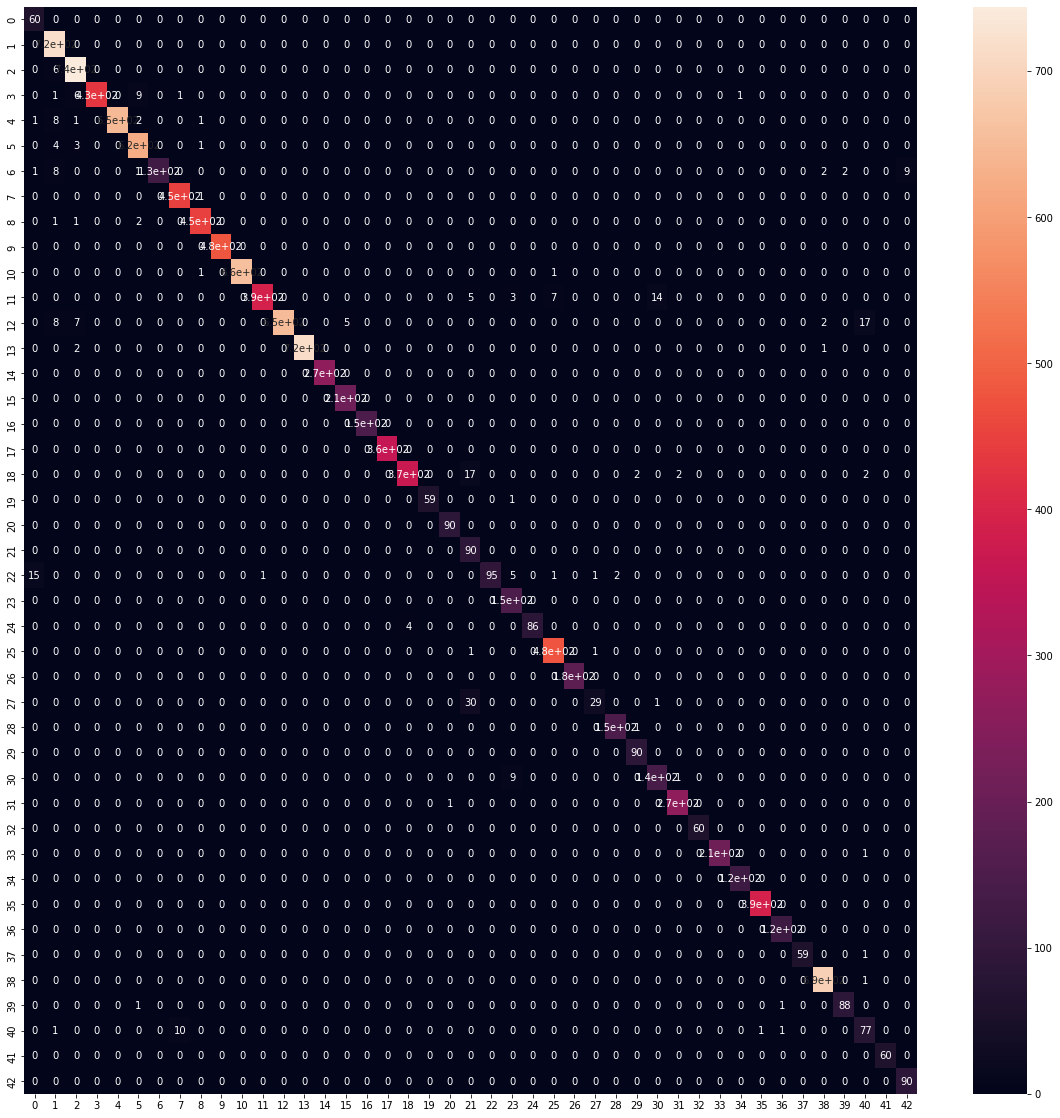

In [ ]:
predict= model.predict(X_Test) 
classPred= np.argmax(predict,axis=1)
# Confusion Matrix
from sklearn.metrics import confusion_matrix

df_cm = pd.DataFrame(confusion_matrix(labels, classPred), index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sbn.heatmap(df_cm, annot=True)

from sklearn.metrics import accuracy_score
print("Accuracy score : %",accuracy_score(labels, classPred)*100)

print(classification_report(labels, classPred))

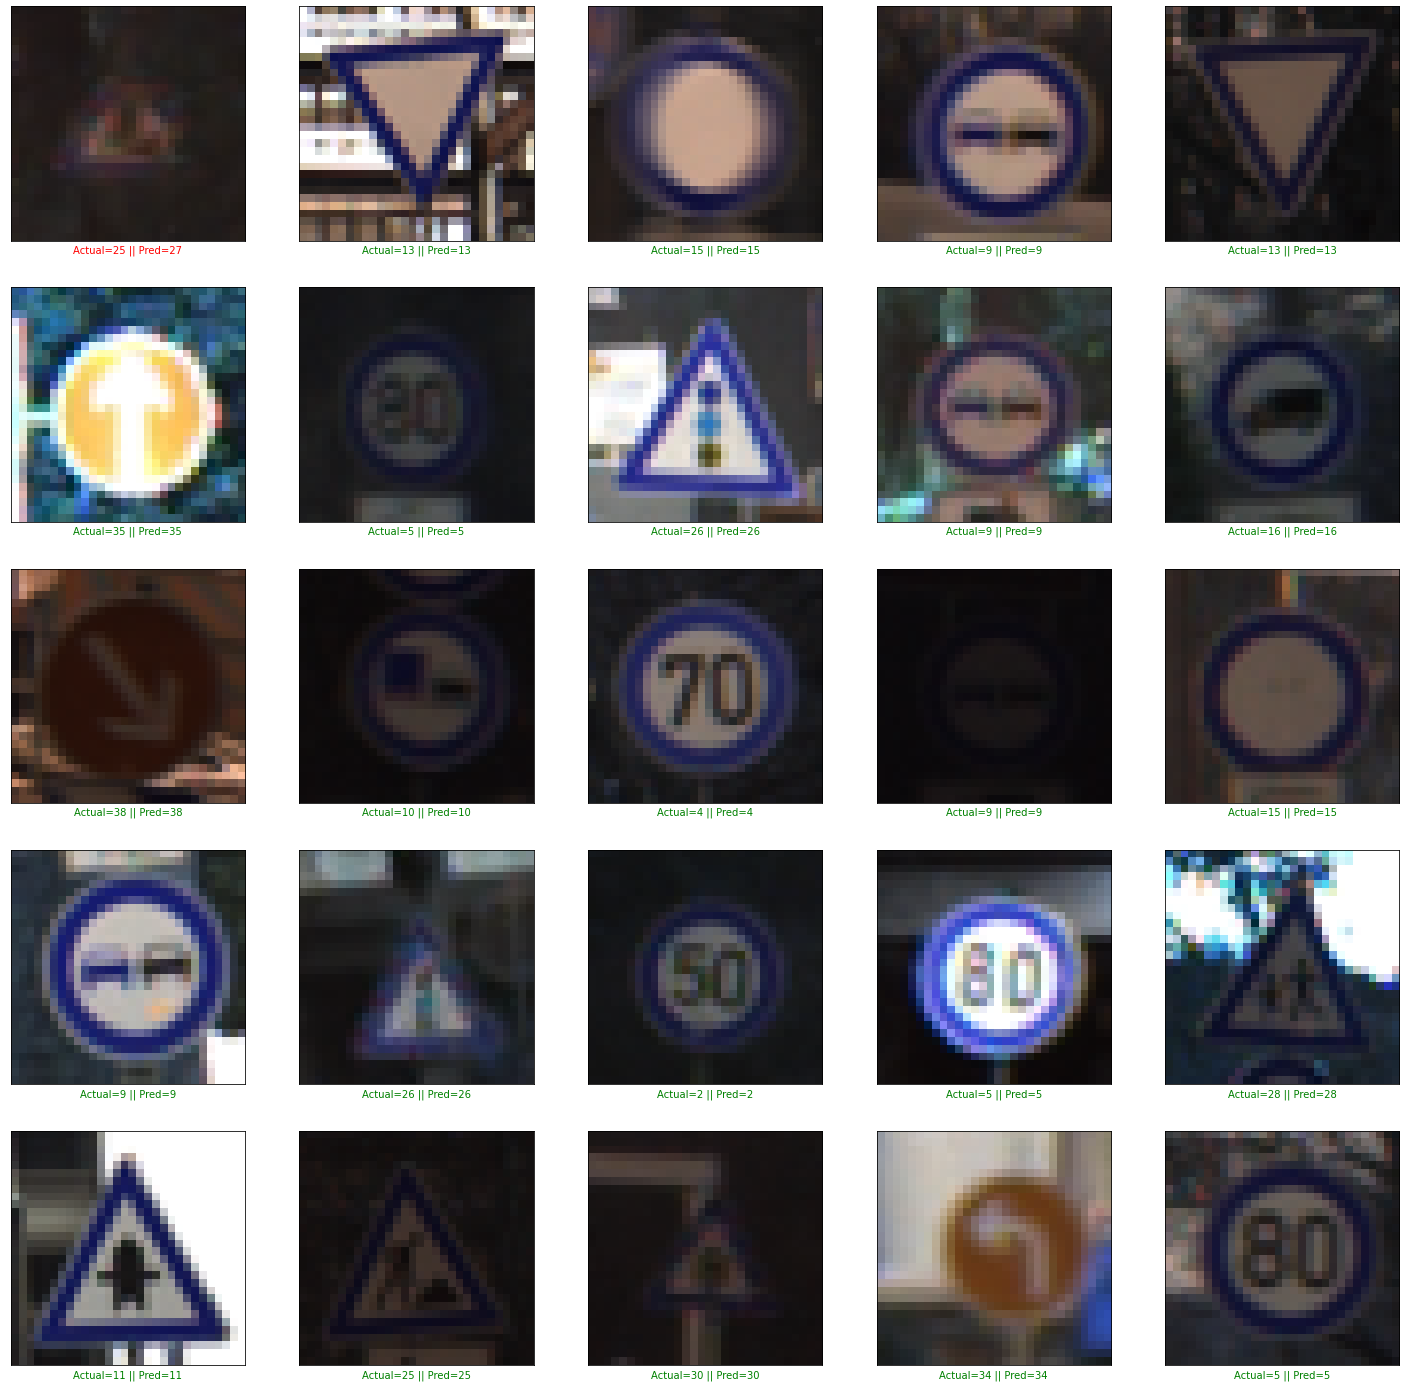

In [ ]:
plt.figure(figsize = (25, 25))

start_index = 50
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = classPred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_Test[start_index + i])
plt.show()

# 5 son

In [ ]:
imageMatrix = []
image = cv2.imread("/content/addsadsadsad.jpg")
imageFromArray = Image.fromarray(image, 'RGB')
resizeImage = imageFromArray.resize((height,width))
imageMatrix.append(np.array(resizeImage))

croppedImage = np.array(imageMatrix)
croppedImage = croppedImage/255
croppedImage

predict= model.predict(croppedImage) 
classPred= np.argmax(predict,axis=1)
plt.imshow(Image.open("/content/addsadsadsad.jpg"))
plt.show()
print(classes[classPred[0]])